In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dc_stat_think.original import *
import dc_stat_think as dcst
import pandas as pd
from scipy import stats

In [3]:
force_a=np.array([1.612, 0.605, 0.327, 0.946, 0.541, 1.539, 0.529, 0.628, 1.453,
       0.297, 0.703, 0.269, 0.751, 0.245, 1.182, 0.515, 0.435, 0.383,
       0.457, 0.73 ]) 

force_b=np.array([0.172, 0.142, 0.037, 0.453, 0.355, 0.022, 0.502, 0.273, 0.72 ,
       0.582, 0.198, 0.198, 0.597, 0.516, 0.815, 0.402, 0.605, 0.711,
       0.614, 0.468])


In [4]:
class PlotsForHypothesis(object):

    def plot_hist(self,values, low=None, high=None):
        plt.figure(figsize=(8,8))
        options = dict(alpha=0.5, color='C0')
        xs, ys, patches = plt.hist(values,
                               density=True,
                               histtype='step', 
                               linewidth=3,
                               **options)
        plt.ylabel('Density')
        plt.tight_layout()
    
        return patches[0]
    def fill_hist(self,low, high, patch):
        options = dict(alpha=0.5, color='red')
        fill = plt.axvspan(low, high, 
                       clip_path=patch,
                       **options)
    def annotate(self,text, x, y, length):
        arrowprops = dict(width=1, headwidth=6, facecolor='black')
        plt.annotate(text,
                     xy=(x, y),
                 xytext=(x, y+length),
                 ha='center',
                 arrowprops=arrowprops)    

In [5]:
class HypothesisTest(PlotsForHypothesis):
    '''
    NULL SIGNIFICANCE HYPOTHESIS TEST 
    
    H0 : means are the same
    
    Ha : they are not 
    
    test_statistic : difference of means under the null hypothesis should be 0 using permutation test
    
    p-value : how many times did i get value that's as extreme as the actual value or more.
    '''
    def __init__(self, data1 , data2):
        self.data1 = data1
        self.data2 = data2
        self.actual_statistic = self.calc_test_statistic(self.data1 , self.data2)
        self.test_stats = self.run_simulation('perm')
        self.size=10000
        self.std_error = np.std(self.test_stats) / self.size
        self.confidence_intervals=np.percentile(self.test_stats , [2.5 , 97.5])
        self.test_statistic_name = 'Different Of Means'
        self.p=self.p_value()
        
    def p_value(self):
        p_value = np.sum(self.test_stats >= self.actual_statistic) / len(self.test_stats)
        return p_value
        
    def calc_test_statistic(self,d1 , d2):
        diff = np.abs(np.mean(d1) - np.mean(d2))
        return diff
    
    def run_simulation(self , kind='perm'):
        
        if(kind == 'perm'):
            
            print("NHST using Permutation Test !")
            perm_replicates = draw_perm_reps(self.data1 , self.data2 , self.calc_test_statistic , size=10000)
            return perm_replicates
        
        elif(kind == 'bootstrap'):
            print("NHST using Bootstrap !")
            
            all_data = np.concatenate((self.data1, self.data2))
            
            global_mean = np.mean(all_data)
            
            shifted_data1 = self.data1 - np.mean(self.data1) + global_mean
            shifted_data2 = self.data2 - np.mean(self.data2) + global_mean

            bs_reps_data1 = draw_bs_reps(shifted_data1 , np.mean, size=10000)
            bs_reps_data2 = draw_bs_reps(shifted_data2 , np.mean, size=10000)

            return np.abs(bs_reps_data1 - bs_reps_data2)

    def evaluate(self):
        self._eval()
        print("95% confidence Interval : " , self.get_confidence_intervals())
        print("P-Value = " , self.p)
        if(self.p <= 0.05):
            print("The Null Hypothesis Is rejected!")
        else :
            print("We failed to Reject the Null Hypothesis")
        print("Sampling size =" , self.size)
        print("Standard Error =" ,self.std_error)
        self.annotate('P-Value' , 1.1*self.actual_statistic , 0.3 , 1)

    def get_confidence_intervals(self):
        '''the analytic way'''
        diff_of_meanss=np.mean(self.data1) - np.mean(self.data2)
        df=len(self.data1) + len(self.data2) -2
        t_value=stats.t.ppf(0.95, df)
        var1_squared=np.var(self.data1) **2
        var2_squared=np.var(self.data2) ** 2
        Sp=np.sqrt((len(self.data1)* var1_squared + len(self.data2) *var2_squared) / (len(self.data1) + len(self.data2) -2))
        factor=np.sqrt(1/len(self.data1) + 1/len(self.data2))
        ci=t_value * Sp * factor
        return (diff_of_meanss - ci ,  diff_of_meanss+ci)
    def _eval(self):
        patch = self.plot_hist(self.test_stats)
        low = self.actual_statistic
        high = np.max(self.test_stats)
        self.fill_hist(low, high, patch)
        plt.title('Distribution of test stat under null')
        plt.axvline(x=self.actual_statistic,color='red', label='Actual Statsitc value')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        print("The Actual Value for "+self.test_statistic_name + " = " + str(self.actual_statistic))


NHST using Permutation Test !
The Actual Value for Different Of Means = 0.28825000000000006
95% confidence Interval :  (0.21898163325595815, 0.35751836674404197)
P-Value =  0.0112
The Null Hypothesis Is rejected!
Sampling size = 10000
Standard Error = 6.954532138003175e-06


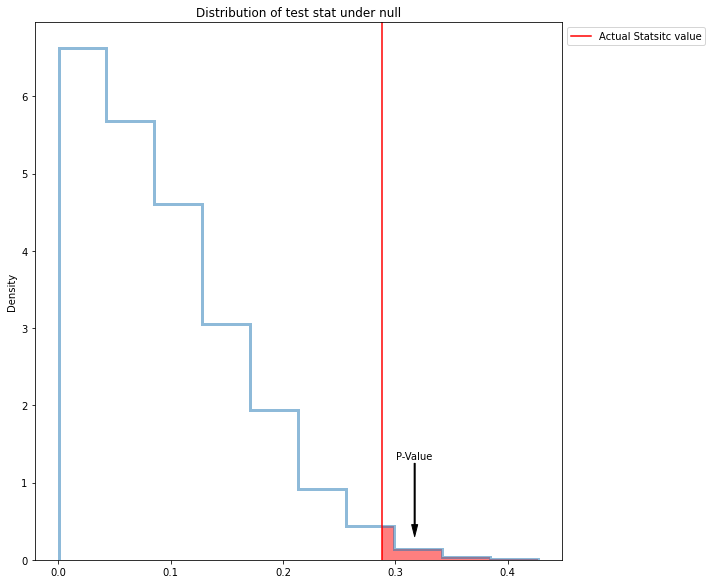

In [6]:
tester=HypothesisTest(force_a , force_b)
tester.evaluate()

# Cohen Effect Size

In [7]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [8]:
CohenEffectSize(force_a , force_b)

0.8619804544879994

In [9]:
score=np.array([16 , 17.5 , 17 , 18 , 17.5 , 18.5,19.5 , 19 , 16.5 , 19.5 , 17 , 18.5 , 17.5 , 
16,18,15,18,20,16.5,16,18,17,16.5,16.5,14,19,13.5,18,18.5,17.5,13,19.5,16,16.5,18.5,20,16,16,17,17,17,15.5
])
#male=0 , female = 1
labels=np.array([0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,1,0,1,1])
print(score.shape , labels.shape)

(42,) (42,)


In [10]:
my_data=pd.DataFrame({'score':score , 'gender':labels})
my_data.head()

,score,gender
0,16.0,0
1,17.5,0
2,17.0,0
3,18.0,0
4,17.5,0


(array([2., 0., 0., 2., 3., 3., 5., 3., 1., 3.]),
 array([13.5 , 14.15, 14.8 , 15.45, 16.1 , 16.75, 17.4 , 18.05, 18.7 ,
        19.35, 20.  ]),
 <BarContainer object of 10 artists>)

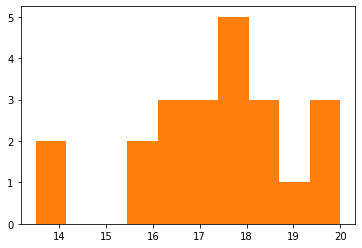

In [11]:
males=my_data[my_data['gender']==0]
males=np.array(males['score'])
plt.hist(males)
plt.hist(males)

(array([1., 0., 0., 2., 4., 2., 4., 3., 1., 3.]),
 array([13.  , 13.65, 14.3 , 14.95, 15.6 , 16.25, 16.9 , 17.55, 18.2 ,
        18.85, 19.5 ]),
 <BarContainer object of 10 artists>)

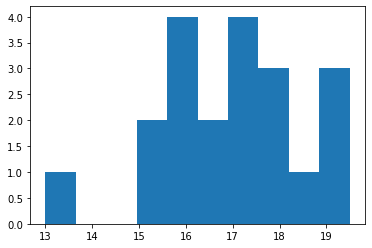

In [12]:
females=my_data[my_data['gender']==1]
females=np.array(females['score'])
plt.hist(females)

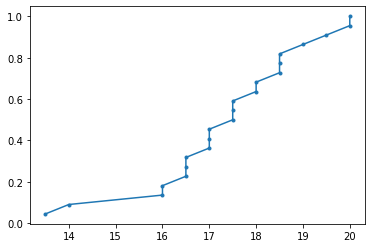

In [13]:
plt.plot(*(ecdf(males)) , marker='.')

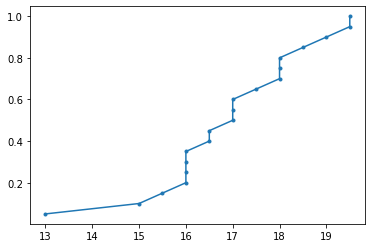

In [14]:
plt.plot(*(ecdf(females)) , marker='.' )

NHST using Permutation Test !
The Actual Value for Different Of Means = 0.41136363636363527
95% confidence Interval :  (-0.9505838657777583, 1.7733111385050289)
P-Value =  0.4296
We failed to Reject the Null Hypothesis
Sampling size = 10000
Standard Error = 3.0289187117844796e-05


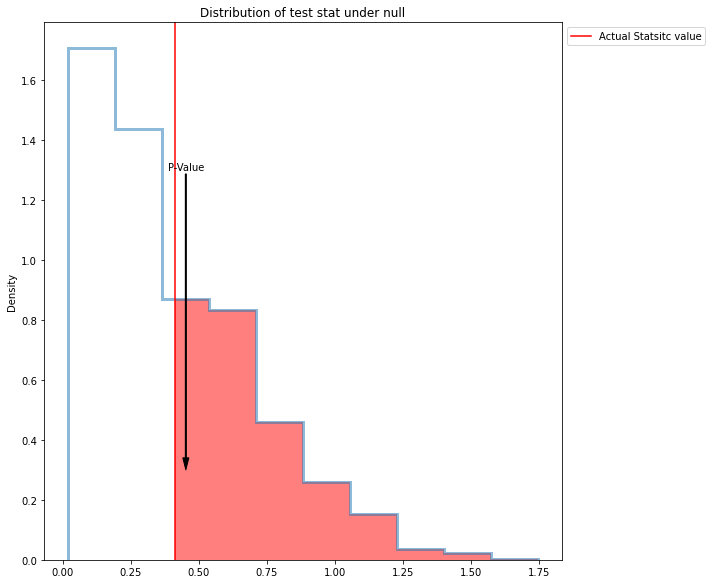

In [15]:
tester=HypothesisTest(males,females)
tester.evaluate()

# K-S Test
## For comparing goodness - of - fit
### measures the maximum distance from 2 cdfs
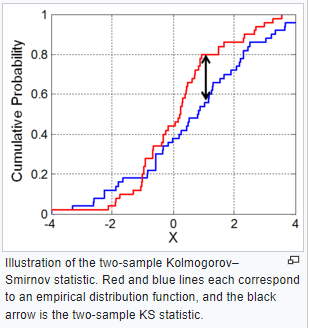

In [16]:
class OneSampleKsTest(HypothesisTest):
    '''
    Kolmogorv-smirnov test for goodness of fit
    measures 2 distribution are the same or no
    H0 : they are the same.
    methods used : permutation , scipy's implementation , critical values from 2 sided table
    '''
    def calc_test_statistic(self,d1 , d2):
        return dcst.ks_stat(d1,d2)
    
    def ks_critical_vals(self,data1 , data2 , alpha=0.05):
        ks=dcst.ks_stat(data1,data2)
        coeff=1.36 # for alpha=0.05
        D=coeff * np.sqrt((len(data1) + len(data2) ) / (len(data1)* len(data2)))
        print("Critical Value = " , D)
        if(ks > D):
            print("As KS is Larger than the Critical Value we Reject the Null Hypothesis")
        else:
            print("as Ks is smaller , we failed to reject the Null Hypothesis")
            
    def evaluate(self):
        self.test_statistic_name="Kolmogorov-Smirnov Test"
        self._eval()
        print("P-Value using Permutation = " , self.p)
        if(self.p <= 0.05):
            print("The Null Hypothesis Is rejected!")
        else :
            print("We failed to Reject the Null Hypothesis")
        print("Sampling size =" , self.size)
        print("Standard Error =" ,self.std_error)
        self.annotate('P-Value' , 1.1*self.actual_statistic , 0.3 , 1)
        self.ks_critical_vals(self.data1,self.data2)
        print("********************using scipy :*************************")
        k,p=stats.ks_2samp(self.data1,self.data2)
        print("K from scipy = " , k)
        print("P-value from scipy= " , p)

In [17]:
class twoSampleKsTest(OneSampleKsTest):
    def calc_test_statistic(self,d1 , d2):
        return stats.ks_2samp(d1,d2)[0]

NHST using Permutation Test !
The Actual Value for Kolmogorov-Smirnov Test = 0.16818181818181818
P-Value using Permutation =  0.6397
We failed to Reject the Null Hypothesis
Sampling size = 10000
Standard Error = 7.804332280669976e-06
Critical Value =  0.42018177884426083
as Ks is smaller , we failed to reject the Null Hypothesis
********************using scipy :*************************
K from scipy =  0.16818181818181818
P-value from scipy=  0.8686770306996385


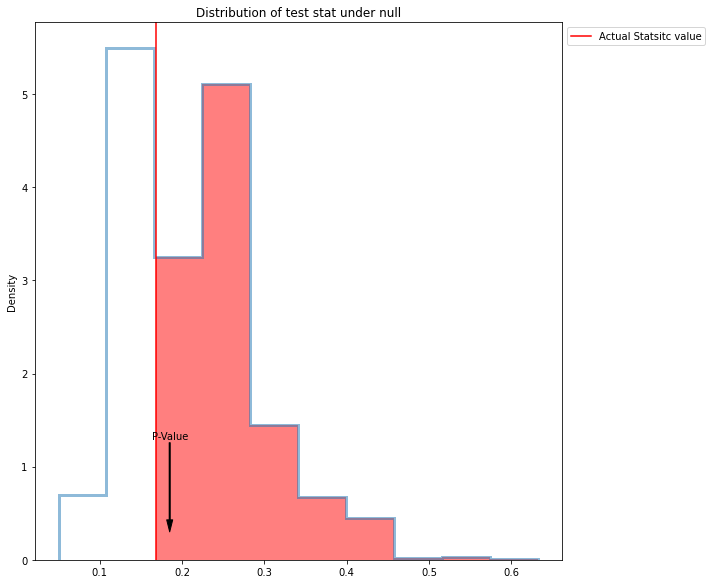

In [18]:
tester=twoSampleKsTest(males , females)
tester.evaluate()

# T test : for comparing 2 sample means
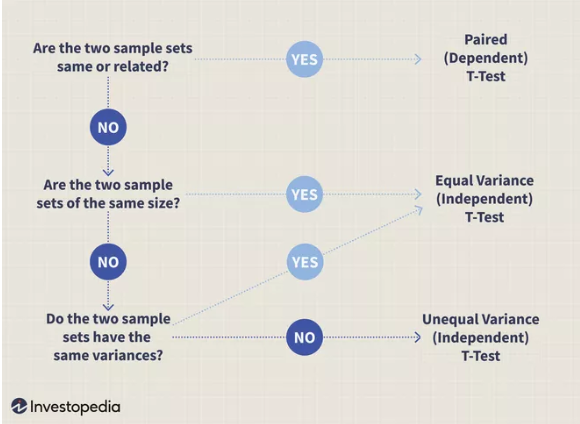

In [108]:
class twoSampleTtest(HypothesisTest):
 
    def calc_test_statistic(self,d1 , d2):
        return stats.ttest_ind(d1,d2)[0]
            
    def evaluate(self):
        self.test_statistic_name="Two sample t-Test"
        self._eval()
        print("P-Value using Permutation = " , self.p)
        if(self.p <= 0.05):
            print("The Null Hypothesis Is rejected!")
        else :
            print("We failed to Reject the Null Hypothesis")
        print("Sampling size =" , self.size)
        print("Standard Error =" ,self.std_error)
        self.annotate('P-Value' , 1.1*self.actual_statistic , 0.3 , 0.2)
        